# Modeling for Snow Depth Prediction

This notebook is focused on preparing the data for modeling, addressing multicollinearity, and creating training, validation, and testing sets. We will proceed with the following steps:
- Loading the Processed Data
- Creating Lag Features and Derived Variables
- Handling Multicollinearity
- Splitting the Data into Training, Validation, and Testing Sets

### 1. Loading Libraries and Processed Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

### 2. Load Processed Data

In [2]:
# Adjust the path based on your current working directory
data_path = os.path.join('..', 'data', 'processed', 'processed_data_for_modeling.csv')

# Load the combined processed data
model_data = pd.read_csv(data_path)

# Ensure 'date' column is in datetime format
model_data['date'] = pd.to_datetime(model_data['date'])

# Display the shape to confirm loading
print(f"Loaded combined data with shape {model_data.shape}")

Loaded combined data with shape (57862, 12)


### 3. Initiating the "Resort" feauture

The data now includes the "resort" feature, we need to handle it appropriately for modeling.  Since 'resort' is a categorical variable, we need to encode it into numerical format using One-Hot encoding.  Furthermore, we'll avoid multicollinearity by dropping one of the dummy variables.

In [3]:
# One-Hot Encode the 'resort' feature
model_data = pd.get_dummies(model_data, columns=['resort'], drop_first=True)

# Display the columns to confirm encoding
print(f"Columns after encoding: {model_data.columns.tolist()}")

Columns after encoding: ['date', 'temperature_min', 'temperature_max', 'precipitation_sum', 'snow_depth', 'season_id', 'is_operating_season', 'snow_depth_lag1', 'snow_depth_lag7', 'temperature_avg', 'temperature_avg_squared', 'resort_cortina_d_ampezzo', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'resort_les_trois_vallees', 'resort_mariborsko_pohorje', 'resort_sestriere', 'resort_solden', 'resort_st_anton', 'resort_st_moritz', 'resort_val_d_isere_tignes', 'resort_val_gardena', 'resort_verbier']


### 4. Preparing Features and Target Variable

Features defined include: 
- temperature_avg
- temperature_avg_squared
- precipitation_sum
- snow_depth_lag1
- snow_depth_lag7
- encoded resort

Defining the target variable - snow_depth

In [9]:
data_operating = model_data[model_data['is_operating_season'] == True].reset_index(drop=True)

print(f"Data shape after filtering for operating season: {data_operating.shape}")

# Define the target variable
y = data_operating['snow_depth']

# Exclude 'date' and 'snow_depth' from features
feature_columns = [col for col in data_operating.columns if col != 'date']

# Create the features DataFrame
X = data_operating[feature_columns].copy()

print(f"Initial shape of X (including 'snow_depth'): {X.shape}")
print(f"Initial shape of y: {y.shape}")

Data shape after filtering for operating season: (39668, 24)
Initial shape of X (including 'snow_depth'): (39668, 23)
Initial shape of y: (39668,)


#### 5. Check for Non-Numeric Columns & Handle "season_id"

Ensure any columns in x that are of data types, object or bool.  Non numeric values need to be handled before modeling.  Subsequently perform one-hot encoding to convert season_id into numeric dummy variables.

In [10]:
# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Non-numeric columns before processing: {non_numeric_cols}")

# Handle 'season_id' column
# One-Hot Encode 'season_id' if it's in the features
if 'season_id' in X.columns:
    # One-Hot Encode 'season_id'
    season_dummies = pd.get_dummies(X['season_id'], prefix='season', drop_first=True)
    # Drop 'season_id' and add the encoded variables
    X = pd.concat([X.drop(columns=['season_id']), season_dummies], axis=1)
    print("One-Hot Encoded 'season_id' and updated X.")
else:
    print("'season_id' column not found in features.")

# Convert boolean columns to integers
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
if bool_columns:
    X[bool_columns] = X[bool_columns].astype(int)
    print(f"Converted boolean columns to integers: {bool_columns}")

# Verify all columns are now numeric
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns after processing: {non_numeric_cols}")
print("Data types after processing:")
print(X.dtypes)

if not non_numeric_cols:
    print("All features are now numeric and ready for Polynomial Features.")
else:
    print("There are still non-numeric features that need to be encoded.")

Non-numeric columns before processing: ['season_id', 'is_operating_season', 'resort_cortina_d_ampezzo', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'resort_les_trois_vallees', 'resort_mariborsko_pohorje', 'resort_sestriere', 'resort_solden', 'resort_st_anton', 'resort_st_moritz', 'resort_val_d_isere_tignes', 'resort_val_gardena', 'resort_verbier']
One-Hot Encoded 'season_id' and updated X.
Converted boolean columns to integers: ['is_operating_season', 'resort_cortina_d_ampezzo', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'resort_les_trois_vallees', 'resort_mariborsko_pohorje', 'resort_sestriere', 'resort_solden', 'resort_st_anton', 'resort_st_moritz', 'resort_val_d_isere_tignes', 'resort_val_gardena', 'resort_verbier', 'season_1991-1992', 'season_1992-1993', 'season_1993-1994', 'season_1994-1995', 'season_1995-1996', 'season_1996-1997', 'season_1997-1998', 'season_1998-1999', 'season_1999-2000', 'season_2000-2001', 'season_2001-2002', 'season_2002-2

### 7. Lag Features

Incorporate lagged values of snow depth and other relevant features to capture temporal dependencies.

In [11]:
# Define lag periods
lags = [1, 7, 14, 21]  # You can adjust these based on domain knowledge

# Features to create lag features for
lag_features = ['snow_depth', 'temperature_avg', 'precipitation_sum']

for feature in lag_features:
    for lag in lags:
        lag_col = f"{feature}_lag{lag}"
        if feature in X.columns:
            X[lag_col] = X[feature].shift(lag)
            print(f"Created lag feature '{lag_col}'.")
        else:
            print(f"Feature '{feature}' not found in X. Skipping lag creation for this feature.")

# Drop rows with NaN values resulting from lagging
# Ensure that any rows dropped are reflected in both X and y
initial_length = len(X)
X = X.dropna().reset_index(drop=True)
y = y.iloc[X.index].reset_index(drop=True)

print(f"Shape of X after adding lag features: {X.shape}")
print(f"Shape of y after adding lag features: {y.shape}")

Created lag feature 'snow_depth_lag1'.
Created lag feature 'snow_depth_lag7'.
Created lag feature 'snow_depth_lag14'.
Created lag feature 'snow_depth_lag21'.
Created lag feature 'temperature_avg_lag1'.
Created lag feature 'temperature_avg_lag7'.
Created lag feature 'temperature_avg_lag14'.
Created lag feature 'temperature_avg_lag21'.
Created lag feature 'precipitation_sum_lag1'.
Created lag feature 'precipitation_sum_lag7'.
Created lag feature 'precipitation_sum_lag14'.
Created lag feature 'precipitation_sum_lag21'.
Shape of X after adding lag features: (39647, 65)
Shape of y after adding lag features: (39647,)


### 8. Handling Multicollinearity

Before splitting the data, it's important to check for multicollinearity among features.

Calculating the Variance Inflation Factor (VIF) for each feature is important.

In [12]:
# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Exclude 'snow_depth' from VIF calculation if present
features_to_exclude = ['snow_depth']
X_vif = X.drop(columns=features_to_exclude, errors='ignore').copy()

# Calculate initial VIF
vif_data = calculate_vif(X_vif)
print("Initial Variance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

# Identify features with VIF > 10
high_vif = vif_data[vif_data['VIF'] > 10]['feature'].tolist()
print(f"Features with VIF > 10: {high_vif}")

# Iteratively remove features with high VIF
for feature in high_vif:
    if feature in X.columns:
        X = X.drop(columns=[feature])
        print(f"Dropped feature '{feature}' due to high VIF.")
        # Recalculate VIF after dropping the feature
        X_vif = X.drop(columns=features_to_exclude, errors='ignore').copy()
        vif_data = calculate_vif(X_vif)
        print(vif_data.sort_values('VIF', ascending=False))
    else:
        print(f"Feature '{feature}' already removed.")

# Final VIF after removal
final_vif = calculate_vif(X_vif)
print("Final Variance Inflation Factors:")
print(final_vif.sort_values('VIF', ascending=False))

/workspace/SkiSnow/venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Initial Variance Inflation Factors:
                    feature        VIF
0           temperature_min        inf
1           temperature_max        inf
6           temperature_avg        inf
3       is_operating_season  73.420689
56     temperature_avg_lag1   5.537389
..                      ...        ...
53         season_2023-2024   1.268330
7   temperature_avg_squared   1.239701
61   precipitation_sum_lag7   1.218813
62  precipitation_sum_lag14   1.210810
63  precipitation_sum_lag21   1.187878

[64 rows x 2 columns]
Features with VIF > 10: ['temperature_min', 'temperature_max', 'is_operating_season', 'temperature_avg']
Dropped feature 'temperature_min' due to high VIF.
                    feature        VIF
2       is_operating_season  73.420689
5           temperature_avg  21.341858
0           temperature_max  17.439587
55     temperature_avg_lag1   5.537389
19           resort_verbier   4.779857
..                      ...        ...
52         season_2023-2024   1.268330
6   t

### 6. Adding Polynomial Features

Now that all non-numeric columns have been handled, we can safely apply Polynomial Features to capture non-linear relationships.

In [13]:

# Define features to apply PolynomialFeatures
selected_features = ['temperature_avg', 'precipitation_sum']  # Adjust based on domain knowledge

# Check which selected features are present in X
available_features = [feature for feature in selected_features if feature in X.columns]
missing_features = [feature for feature in selected_features if feature not in X.columns]

if missing_features:
    print(f"Cannot apply PolynomialFeatures to missing features: {missing_features}")
    print("Proceeding with available features only.")
else:
    print("All selected features are available for PolynomialFeatures.")

if available_features:
    # Initialize PolynomialFeatures with degree 2
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    # Fit and transform only the available features
    X_poly_selected = poly.fit_transform(X[available_features])
    
    # Get the new feature names for selected features
    poly_features_selected = poly.get_feature_names_out(available_features)
    
    # Create a DataFrame for polynomial features
    X_poly_df = pd.DataFrame(X_poly_selected, columns=poly_features_selected)
    
    # Drop the original selected features from X
    X = X.drop(columns=available_features)
    
    # Concatenate the polynomial features back to X
    X = pd.concat([X.reset_index(drop=True), X_poly_df.reset_index(drop=True)], axis=1)
    
    print(f"Shape of X after adding polynomial features to selected features: {X.shape}")
else:
    print("No features available for PolynomialFeatures. Skipping this step.")

Cannot apply PolynomialFeatures to missing features: ['temperature_avg']
Proceeding with available features only.
Shape of X after adding polynomial features to selected features: (39647, 62)


### 9. Splitting the Data

Since the data is time-series data, it's important to split it in a way that respects the temporal order tand thus avoid data leakage.

#### 9 (a) Split the data into training, validation, and test sets using time-based splits.

In [14]:
# Define the sizes for training, validation, and testing sets
total_length = len(X)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = total_length - train_size - val_size

# Split the data
X_train = X.iloc[:train_size].reset_index(drop=True)
y_train = y.iloc[:train_size].reset_index(drop=True)

X_val = X.iloc[train_size:train_size + val_size].reset_index(drop=True)
y_val = y.iloc[train_size:train_size + val_size].reset_index(drop=True)

X_test = X.iloc[train_size + val_size:].reset_index(drop=True)
y_test = y.iloc[train_size + val_size:].reset_index(drop=True)

print(f"Training set size: {X_train.shape}, y_train size: {y_train.shape}")
print(f"Validation set size: {X_val.shape}, y_val size: {y_val.shape}")
print(f"Test set size: {X_test.shape}, y_test size: {y_test.shape}")

# Verify alignment
assert X_train.shape[0] == y_train.shape[0], "Mismatch in training set."
assert X_val.shape[0] == y_val.shape[0], "Mismatch in validation set."
assert X_test.shape[0] == y_test.shape[0], "Mismatch in test set."

print("All splits are aligned correctly.")

Training set size: (27752, 62), y_train size: (27752,)
Validation set size: (5947, 62), y_val size: (5947,)
Test set size: (5948, 62), y_test size: (5948,)
All splits are aligned correctly.


### 10. Proceeding with Modeling

The data is now prepared.  We can proceed to build and evaluate the models.

#### 10 (a) Training The Model

In [15]:
print('season_id' in X_train.columns)
print(X_train.dtypes)

non_numeric_cols_train = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns in X_train: {non_numeric_cols_train}")

False
snow_depth                  float64
snow_depth_lag1             float64
snow_depth_lag7             float64
temperature_avg_squared     float64
resort_cortina_d_ampezzo      int64
                             ...   
precipitation_sum_lag7      float64
precipitation_sum_lag14     float64
precipitation_sum_lag21     float64
precipitation_sum           float64
precipitation_sum^2         float64
Length: 62, dtype: object
Non-numeric columns in X_train: []


In [16]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

# Initialize Grid Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", random_search.best_params_)

# Use the best estimator
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\nOptimised Random Forest Regressor Evaluation on Validation Set:")
print(f"Mean Squared Error: {mse_val:.2f}")
print(f"R-squared: {r2_val:.2f}")

# Predict on the test set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate the model on the test set
print(f"\nLength of y_test: {len(y_test)}")
print(f"Length of y_test_pred: {len(y_test_pred)}")

# Verify alignment before evaluation
assert len(y_test) == len(y_test_pred), "Mismatch in number of samples between y_test and y_test_pred."

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nOptimised Random Forest Regressor Evaluation on Test Set:")
print(f"Mean Squared Error: {mse_test:.2f}")
print(f"R-squared: {r2_test:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}

optimised Random Forest Regressor Evaluation on Validation Set:
Mean Squared Error: 1173.11
R-squared: 0.94
Length of y_test: 5948
Length of y_test_pred: 5948

Optimised Random Forest Regressor Evaluation on Test Set:
Mean Squared Error: 1452.32
R-squared: 0.93


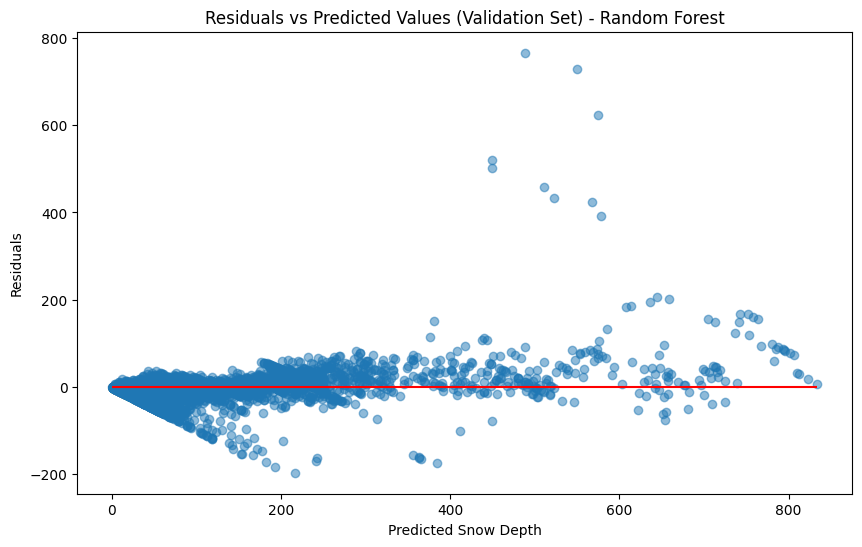

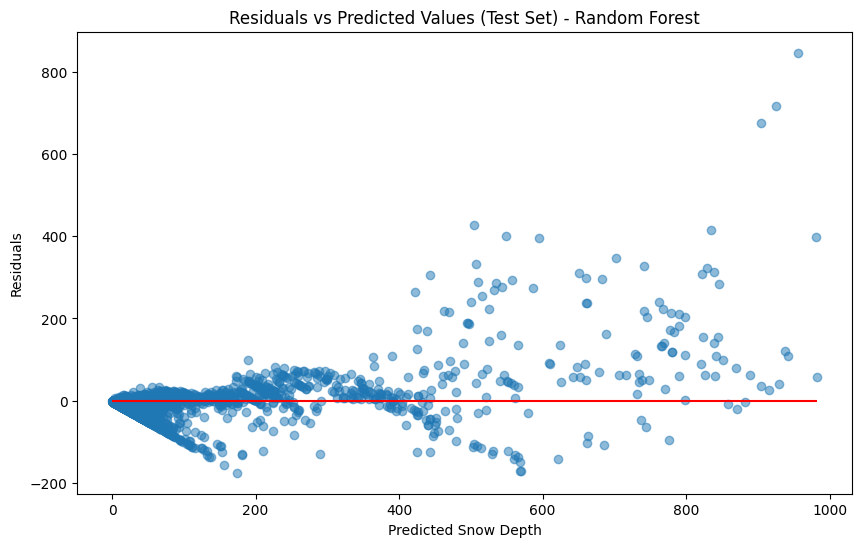

In [17]:
# Residuals on validation set
residuals_val = y_val - y_val_pred
plt.figure(figsize=(10,6))
plt.scatter(y_val_pred, residuals_val, alpha=0.5)
plt.hlines(y=0, xmin=y_val_pred.min(), xmax=y_val_pred.max(), colors='r')
plt.xlabel('Predicted Snow Depth')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Validation Set) - Random Forest')
plt.show()

# Residuals on test set
residuals_test = y_test - y_test_pred
plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r')
plt.xlabel('Predicted Snow Depth')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Test Set) - Random Forest')
plt.show()

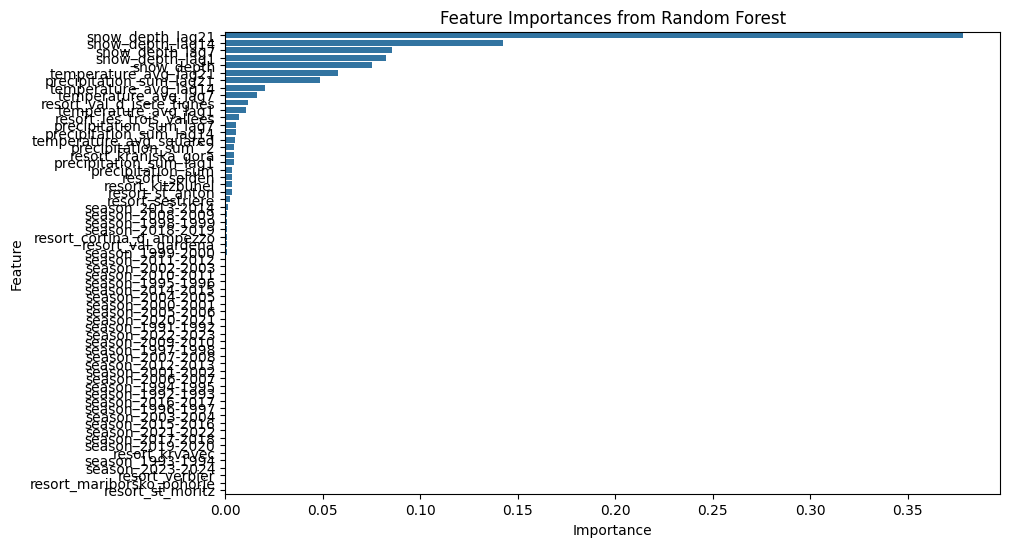

In [18]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()